## Procesing GNSS data for multiple receivers & producing VOD

### Step 1: Load libraries

This chunk imports libraries with important modules & sets the working environment where the jupyterlab notebook file is imported to.

In [1]:
%load_ext autoreload
%autoreload 2
import gnssvod as gv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pdb
import importlib
import zipfile
import os
import xarray as xr
import glob
import shutil
from gnssvod.hemistats.hemistats import hemibuild
#import georinex as gr
#import qgrid as interactive table 
from matplotlib.collections import PatchCollection
import matplotlib.dates as mdates
import shutil
from matplotlib import rcParams
from datetime import datetime, timedelta

### Step 2: Time intervals

Choose the interval you want to pull data from (the study period). Input the start date in dd-mm-yyyy format. Use periods= to select the number of days from the start day you want data from.

In [2]:
startday = pd.to_datetime('10-02-2025',format='%d-%m-%Y')
timeintervals=pd.interval_range(start=startday, periods=150, freq='D', closed='left')
timeintervals

IntervalIndex([[2025-02-10 00:00:00, 2025-02-11 00:00:00),
               [2025-02-11 00:00:00, 2025-02-12 00:00:00),
               [2025-02-12 00:00:00, 2025-02-13 00:00:00),
               [2025-02-13 00:00:00, 2025-02-14 00:00:00),
               [2025-02-14 00:00:00, 2025-02-15 00:00:00),
               [2025-02-15 00:00:00, 2025-02-16 00:00:00),
               [2025-02-16 00:00:00, 2025-02-17 00:00:00),
               [2025-02-17 00:00:00, 2025-02-18 00:00:00),
               [2025-02-18 00:00:00, 2025-02-19 00:00:00),
               [2025-02-19 00:00:00, 2025-02-20 00:00:00),
               ...
               [2025-06-30 00:00:00, 2025-07-01 00:00:00),
               [2025-07-01 00:00:00, 2025-07-02 00:00:00),
               [2025-07-02 00:00:00, 2025-07-03 00:00:00),
               [2025-07-03 00:00:00, 2025-07-04 00:00:00),
               [2025-07-04 00:00:00, 2025-07-05 00:00:00),
               [2025-07-05 00:00:00, 2025-07-06 00:00:00),
               [2025-07-06 00:00:00, 

### Step 3: Read RINEX files

We then proceed to read the RINEX files. Indicate the location of observation (.*O) files using the pattern= row, and the location of the your output folder (for .nc files) using the outputdir= row. Sometimes we could get the following error:

ValueError: Missing an approximate antenna position. Provide the argument ‘approx_position’ to preprocess()

* Make sure to update to your own path. 

We only need to keep the S* variables to calculate VOD.
Increase or decrease the interval to change the number of observations kept, but keeping it around 15 seconds is recommended.

In [3]:
# option for batch processing, example with my files- again, approx-position is for an error
#batch processing for one station
pattern= {'YoungPine-1':'/Users/coopercollins/Box/Project_MetoliusGNSS/VOD/Data/GNSS/extracted/youngpine/youngpine_tower/*.*O'}
outputdir={'YoungPine-1':'/Users/coopercollins/Box/Project_MetoliusGNSS/VOD/Data/GNSS/extracted/youngpine/youngpine_tower/youngpine_tower_nc/'  }
#approx_position=[2481170.8276 -5525721.2902,1992311.7021 ]
keepvars=['S?','S??']
#gv.preprocess(pattern,interval='15s',keepvars=keepvars,outputdir=outputdir,approx_position=approx_position)
gv.preprocess(pattern,interval='15s',keepvars=keepvars,outputdir=outputdir)

Created a temporary directory at /var/folders/zy/x63zv75j4zxbjxjc77btggbr0000gt/T/tmpg3jh71yh
Reach01_raw_20250322194324.nc already exists, skipping.. (pass overwrite=True to overwrite)
Reach01_raw_20250405202518.nc already exists, skipping.. (pass overwrite=True to overwrite)
Reach01_raw_20250411202524.nc already exists, skipping.. (pass overwrite=True to overwrite)
Reach01_raw_20250327194328.nc already exists, skipping.. (pass overwrite=True to overwrite)
Reach01_raw_20250422202534.nc already exists, skipping.. (pass overwrite=True to overwrite)
Reach01_raw_20250512202554.nc already exists, skipping.. (pass overwrite=True to overwrite)
Reach01_raw_20250408202521.nc already exists, skipping.. (pass overwrite=True to overwrite)
Reach01_raw_20250424202537.nc already exists, skipping.. (pass overwrite=True to overwrite)
Reach01_raw_20250428202541.nc already exists, skipping.. (pass overwrite=True to overwrite)
Reach01_raw_20250324194326.nc already exists, skipping.. (pass overwrite=True 

If an observation file has already been processed into a .nc file in the output folder, it will be automatically skipped unless you pass overwrite=True

Continue this next portion in a separate folder, we call ours gnss_gathering. Name and provide the paths for all of the .nc folders you want to calculate VOD from.

This section will not run if one of the .nc folders mentioned in your path is empty, even if its not listed as one of the sensors you're concatenating. 

In [4]:
#pairing and concatenating--- starting by establishing path to .nc files per station, replace with own path 
pattern={'YoungPine-1':'/Users/coopercollins/Box/Project_MetoliusGNSS/VOD/Data/GNSS/extracted/youngpine/youngpine_tower/youngpine_tower_nc/*.nc',
        'YoungPine-2':'/Users/coopercollins/Box/Project_MetoliusGNSS/VOD/Data/GNSS/extracted/youngpine/youngpine_pheno/youngpine_pheno_nc/*.nc',
        'MaturePine-1':'/Users/coopercollins/Box/Project_MetoliusGNSS/VOD/Data/GNSS/extracted/maturepine/maturepine_tower/maturepine_tower_nc/*.nc',
        'MaturePine-2':'/Users/coopercollins/Box/Project_MetoliusGNSS/VOD/Data/GNSS/extracted/maturepine/maturepine_footprint/maturepine_footprint_nc/*.nc'}

In [5]:
#re-establish time intervals - this will be necessary when you want to look at a specific period of data. 
startday = pd.to_datetime('20-02-2025',format='%d-%m-%Y')
timeintervals=pd.interval_range(start=startday, periods=150, freq='D', closed='left')
timeintervals

IntervalIndex([[2025-02-20 00:00:00, 2025-02-21 00:00:00),
               [2025-02-21 00:00:00, 2025-02-22 00:00:00),
               [2025-02-22 00:00:00, 2025-02-23 00:00:00),
               [2025-02-23 00:00:00, 2025-02-24 00:00:00),
               [2025-02-24 00:00:00, 2025-02-25 00:00:00),
               [2025-02-25 00:00:00, 2025-02-26 00:00:00),
               [2025-02-26 00:00:00, 2025-02-27 00:00:00),
               [2025-02-27 00:00:00, 2025-02-28 00:00:00),
               [2025-02-28 00:00:00, 2025-03-01 00:00:00),
               [2025-03-01 00:00:00, 2025-03-02 00:00:00),
               ...
               [2025-07-10 00:00:00, 2025-07-11 00:00:00),
               [2025-07-11 00:00:00, 2025-07-12 00:00:00),
               [2025-07-12 00:00:00, 2025-07-13 00:00:00),
               [2025-07-13 00:00:00, 2025-07-14 00:00:00),
               [2025-07-14 00:00:00, 2025-07-15 00:00:00),
               [2025-07-15 00:00:00, 2025-07-16 00:00:00),
               [2025-07-16 00:00:00, 

In [6]:
#concatenating. Reference station always goes first. Replace with your own device path & sensor pairings
# YoungPine
pairingsYP={'YoungPine':('YoungPine-1','YoungPine-2')}
outputdirYP={'YoungPine':'/Users/coopercollins/Box/Project_MetoliusGNSS/VOD/Data/GNSS/gnss_gathering/yp_pheno_vod/'}
keepvarsYP=['S?','S??','Azimuth','Elevation']
outYP=gv.gather_stations(pattern,pairingsYP,timeintervals,outputresult=True,outputdir=outputdirYP)
outYP

# MaturePine
pairingsMP={'MaturePine':('MaturePine-1','MaturePine-2')}
outputdirMP={'MaturePine':'/Users/coopercollins/Box/Project_MetoliusGNSS/VOD/Data/GNSS/gnss_gathering/mp_footprint_vod/'}
keepvarsMP=['S?','S??','Azimuth','Elevation']
outMP=gv.gather_stations(pattern,pairingsMP,timeintervals,outputresult=True,outputdir=outputdirMP)
outMP

Extracting Epochs from files
----- Processing YoungPine
-- Processing interval [2025-02-20 00:00:00, 2025-02-21 00:00:00)
Found 0 file(s) for YoungPine-1
No data for station YoungPine-1.
Found 0 file(s) for YoungPine-2
No data for station YoungPine-2.
No data at all for that interval, skipping..
-- Processing interval [2025-02-21 00:00:00, 2025-02-22 00:00:00)
Found 0 file(s) for YoungPine-1
No data for station YoungPine-1.
Found 0 file(s) for YoungPine-2
No data for station YoungPine-2.
No data at all for that interval, skipping..
-- Processing interval [2025-02-22 00:00:00, 2025-02-23 00:00:00)
Found 0 file(s) for YoungPine-1
No data for station YoungPine-1.
Found 0 file(s) for YoungPine-2
No data for station YoungPine-2.
No data at all for that interval, skipping..
-- Processing interval [2025-02-23 00:00:00, 2025-02-24 00:00:00)
Found 0 file(s) for YoungPine-1
No data for station YoungPine-1.
Found 0 file(s) for YoungPine-2
No data for station YoungPine-2.
No data at all for that i

{'MaturePine':                                        S1C   S1X   S2C   S2I  S2X  S7I   S7X  \
 Station      Epoch               SV                                            
 MaturePine-1 2025-03-22 18:33:30 C23   NaN   NaN   NaN  46.0  NaN  NaN   NaN   
                                  C27   NaN   NaN   NaN  42.8  NaN  NaN   NaN   
                                  C28   NaN   NaN   NaN  48.0  NaN  NaN   NaN   
                                  C37   NaN   NaN   NaN  47.9  NaN  NaN   NaN   
                                  E02   NaN  39.7   NaN   NaN  NaN  NaN  32.6   
 ...                                    ...   ...   ...   ...  ...  ...   ...   
 MaturePine-2 2025-05-06 20:28:00 R12  39.8   NaN  37.7   NaN  NaN  NaN   NaN   
                                  R13  39.8   NaN   NaN   NaN  NaN  NaN   NaN   
                                  R14  34.3   NaN  30.6   NaN  NaN  NaN   NaN   
                                  R22  46.6   NaN  35.2   NaN  NaN  NaN   NaN   
              

The portion below I adapt for different station pairings

In [7]:
# Mature
dsMP = xr.open_mfdataset('/Users/coopercollins/Box/Project_MetoliusGNSS/VOD/Data/GNSS/gnss_gathering/mp_footprint_vod/*.nc',combine='nested',concat_dim='Epoch')
dsMP

# Young Pine
dsYP = xr.open_mfdataset('/Users/coopercollins/Box/Project_MetoliusGNSS/VOD/Data/GNSS/gnss_gathering/yp_pheno_vod/*.nc',combine='nested',concat_dim='Epoch')
dsYP

<xarray.Dataset> Size: 7GB
Dimensions:    (Station: 2, Epoch: 368597, SV: 123)
Coordinates:
  * Station    (Station) <U11 88B 'YoungPine-1' 'YoungPine-2'
  * SV         (SV) <U3 1kB 'C06' 'C07' 'C08' 'C09' ... 'R23' 'R24' 'R26' 'R27'
  * Epoch      (Epoch) datetime64[ns] 3MB 2025-03-11T19:39:45 ... 2025-05-14T...
Data variables:
    S1C        (Station, Epoch, SV) float64 725MB dask.array<chunksize=(1, 1041, 65), meta=np.ndarray>
    S1X        (Station, Epoch, SV) float64 725MB dask.array<chunksize=(1, 1041, 65), meta=np.ndarray>
    S2C        (Station, Epoch, SV) float64 725MB dask.array<chunksize=(1, 1041, 65), meta=np.ndarray>
    S2I        (Station, Epoch, SV) float64 725MB dask.array<chunksize=(1, 1041, 65), meta=np.ndarray>
    S2X        (Station, Epoch, SV) float64 725MB dask.array<chunksize=(1, 1041, 65), meta=np.ndarray>
    S7I        (Station, Epoch, SV) float64 725MB dask.array<chunksize=(1, 1041, 65), meta=np.ndarray>
    S7X        (Station, Epoch, SV) float64 725MB dask.array<chunksize=(1, 1041, 65), meta=np.ndarray>
    Azimuth    (Station, Epoch, SV) float64 725MB dask.array<chunksize=(1, 1041, 65), meta=np.ndarray>
    Elevation  (Station, Epoch, SV) float64 725MB dask.array<chunksize=(1, 1041, 65), meta=np.ndarray>

In [8]:
# reorder the dataframes
dfMP =dsMP.to_dataframe().dropna(how='all').reorder_levels(["Station","Epoch","SV"]).sort_index()
dfMP

dfYP =dsYP.to_dataframe().dropna(how='all').reorder_levels(["Station","Epoch","SV"]).sort_index()
dfYP


S1C  S1X   S2C   S2I  S2X  S7I  S7X  \
Station     Epoch               SV                                          
YoungPine-1 2025-03-21 19:43:30 C27   NaN  NaN   NaN  49.0  NaN  NaN  NaN   
                                C28   NaN  NaN   NaN  42.0  NaN  NaN  NaN   
                                C29   NaN  NaN   NaN  40.0  NaN  NaN  NaN   
                                C30   NaN  NaN   NaN  49.0  NaN  NaN  NaN   
                                C36   NaN  NaN   NaN  48.0  NaN  NaN  NaN   
...                                   ...  ...   ...   ...  ...  ...  ...   
YoungPine-2 2025-05-05 20:02:15 R11  48.6  NaN  43.0   NaN  NaN  NaN  NaN   
                                R12  49.1  NaN  40.3   NaN  NaN  NaN  NaN   
                                R20  34.8  NaN  33.9   NaN  NaN  NaN  NaN   
                                R21  45.1  NaN  37.4   NaN  NaN  NaN  NaN   
                                R22  43.8  NaN  37.4   NaN  NaN  NaN  NaN   

                                     Azimuth  Elevation  
Station     Epoch               SV                       
YoungPine-1 2025-03-21 19:43:30 C27     55.6       56.3  
                                C28     50.1       12.6  
                                C29   -131.2       13.4  
                                C30   -138.2       67.3  
                                C36    -66.1       61.0  
...                                      ...        ...  
YoungPine-2 2025-05-05 20:02:15 R11   -135.1       45.0  
                                R12    -48.4       37.7  
                                R20     56.9       25.6  
                                R21     -2.8       63.3  
                                R22    -87.0       30.3  

[23094087 rows x 9 columns]

In [9]:
# intialize hemispheric grid
hemi = gv.hemibuild(4)
hemi

In [10]:
# show 
hemi.grid

,azi,ele,azimin,azimax,elemin,elemax
CellID,,,,,,
0,0.000000,90.0,0.000000,360.000000,88.0,90.0
1,22.500000,86.0,0.000000,45.000000,84.0,88.0
2,67.500000,86.0,45.000000,90.000000,84.0,88.0
3,112.500000,86.0,90.000000,135.000000,84.0,88.0
4,157.500000,86.0,135.000000,180.000000,84.0,88.0
...,...,...,...,...,...,...
1523,345.789474,6.0,344.210526,347.368421,4.0,8.0
1524,348.947368,6.0,347.368421,350.526316,4.0,8.0
1525,352.105263,6.0,350.526316,353.684211,4.0,8.0


In [ ]:

# get patches
patches = hemi.patches() 
patches

CellID
0       Rectangle(xy=(0, 0), width=6.28319, height=2, ...
1       Rectangle(xy=(0, 2), width=0.785398, height=4,...
2       Rectangle(xy=(0.785398, 2), width=0.785398, he...
3       Rectangle(xy=(1.5708, 2), width=0.785398, heig...
4       Rectangle(xy=(2.35619, 2), width=0.785398, hei...
                              ...                        
1523    Rectangle(xy=(6.00761, 82), width=0.0551157, h...
1524    Rectangle(xy=(6.06272, 82), width=0.0551157, h...
1525    Rectangle(xy=(6.11784, 82), width=0.0551157, h...
1526    Rectangle(xy=(6.17295, 82), width=0.0551157, h...
1527    Rectangle(xy=(6.22807, 82), width=0.0551157, h...
Name: Patches, Length: 1528, dtype: object

In [12]:
# classify vod into grid cells
newdfMP = hemi.add_CellID(dfMP)
newdfMP

newdfYP = hemi.add_CellID(dfYP)
newdfYP

S1C  S1X   S2C   S2I  S2X  S7I  S7X  \
Station     Epoch               SV                                          
YoungPine-1 2025-03-21 19:43:30 C27   NaN  NaN   NaN  49.0  NaN  NaN  NaN   
                                C28   NaN  NaN   NaN  42.0  NaN  NaN  NaN   
                                C29   NaN  NaN   NaN  40.0  NaN  NaN  NaN   
                                C30   NaN  NaN   NaN  49.0  NaN  NaN  NaN   
                                C36   NaN  NaN   NaN  48.0  NaN  NaN  NaN   
...                                   ...  ...   ...   ...  ...  ...  ...   
YoungPine-2 2025-05-05 20:02:15 R11  48.6  NaN  43.0   NaN  NaN  NaN  NaN   
                                R12  49.1  NaN  40.3   NaN  NaN  NaN  NaN   
                                R20  34.8  NaN  33.9   NaN  NaN  NaN  NaN   
                                R21  45.1  NaN  37.4   NaN  NaN  NaN  NaN   
                                R22  43.8  NaN  37.4   NaN  NaN  NaN  NaN   

                                     Azimuth  Elevation  CellID  
Station     Epoch               SV                               
YoungPine-1 2025-03-21 19:43:30 C27     55.6       56.3     230  
                                C28     50.1       12.6    1205  
                                C29   -131.2       13.4    1260  
                                C30   -138.2       67.3     148  
                                C36    -66.1       61.0     211  
...                                      ...        ...     ...  
YoungPine-2 2025-05-05 20:02:15 R11   -135.1       45.0     472  
                                R12    -48.4       37.7     665  
                                R20     56.9       25.6     888  
                                R21     -2.8       63.3     220  
                                R22    -87.0       30.3     848  

[20930467 rows x 10 columns]

In [13]:
# Calculate average statistics per grid cell using the base pandas functions.
hemi_averageMP = newdfMP.groupby(['CellID','Station']).mean()
hemi_averageMP

hemi_averageYP = newdfYP.groupby(['CellID','Station']).mean()
hemi_averageYP

S1C        S1X        S2C        S2I        S2X  \
CellID Station                                                              
0      YoungPine-1  46.862394  45.820817  42.160606  47.970000  43.806055   
       YoungPine-2  46.247027  45.891407  40.438636  48.338620  42.056265   
1      YoungPine-1  48.530016  45.906874        NaN  48.036622  43.878227   
       YoungPine-2  48.949525  45.571305        NaN  47.659268  42.748847   
2      YoungPine-1  48.092101  45.616486  42.435398  48.111557  43.895342   
...                       ...        ...        ...        ...        ...   
1525   YoungPine-2  30.426886        NaN  29.650393        NaN        NaN   
1526   YoungPine-1  42.398150        NaN  38.257962        NaN        NaN   
       YoungPine-2  27.703599        NaN  24.759242        NaN        NaN   
1527   YoungPine-1  42.243116        NaN  37.816039        NaN        NaN   
       YoungPine-2  28.633270        NaN  27.994643        NaN        NaN   

                          S7I        S7X    Azimuth  Elevation  
CellID Station                                                  
0      YoungPine-1  39.762449  40.972497  -1.864828  88.666655  
       YoungPine-2  42.216136  40.189092  -1.255509  88.676206  
1      YoungPine-1  38.868558  41.080981  20.394116  85.973799  
       YoungPine-2  42.753415  41.189616  20.225848  85.992532  
2      YoungPine-1  37.546703  40.752868  71.626516  85.776138  
...                       ...        ...        ...        ...  
1525   YoungPine-2        NaN        NaN  -7.885534   5.422110  
1526   YoungPine-1        NaN        NaN  -4.806428   4.816802  
       YoungPine-2        NaN        NaN  -4.809331   4.799277  
1527   YoungPine-1        NaN        NaN  -1.720293   4.807883  
       YoungPine-2        NaN        NaN  -1.649955   4.817299  

[2724 rows x 9 columns]

In [14]:
# set which data files should be loaded
patternMP = '/Users/coopercollins/Box/Project_MetoliusGNSS/VOD/Data/GNSS/gnss_gathering/mp_footprint_vod/*.nc'
# define how to associate stations together. Always put reference station first.
pairingsMP={'MaturePine':('MaturePine-1','MaturePine-2')}
# define if some observables with similar frequencies should be combined together. In the future, this should be replaced by the selection of frequency bands.
bandsMP = {'VOD1':['S1','S1X','S1C'],'VOD2':['S2','S2X','S2C']}

vodMP = gv.calc_vod(patternMP,pairingsMP,bandsMP)
vodMP = vodMP['MaturePine']
vodMP

# set which data files should be loaded
patternYP = '/Users/coopercollins/Box/Project_MetoliusGNSS/VOD/Data/GNSS/gnss_gathering/yp_pheno_vod/*.nc'
# define how to associate stations together. Always put reference station first.
pairingsYP={'YoungPine':('YoungPine-1','YoungPine-2')}
# define if some observables with similar frequencies should be combined together. In the future, this should be replaced by the selection of frequency bands.
bandsYP = {'VOD1':['S1','S1X','S1C'],'VOD2':['S2','S2X','S2C']}

vodYP = gv.calc_vod(patternYP,pairingsYP,bandsYP)
vodYP = vodYP['YoungPine']
vodYP

VOD1      VOD2  Azimuth  Elevation
Epoch               SV                                         
2025-04-19 00:00:00 C12       NaN       NaN    -57.7       10.5
                    C19       NaN       NaN    124.4       67.6
                    C20       NaN       NaN     49.7       35.9
                    C22       NaN       NaN   -165.2       29.2
                    C24       NaN       NaN    -73.8        4.9
...                           ...       ...      ...        ...
2025-04-29 23:59:45 R09  0.300402  0.321120     -7.4        4.3
                    R16  0.394878  0.315902    -57.7       10.4
                    R17  0.681785  0.764425    -17.3       63.8
                    R18  0.517257 -0.022489    -46.2       19.0
                    R24  1.650430  2.355301    107.0       48.3

[8998147 rows x 4 columns]

In [15]:
# intialize hemispheric grid
hemi = gv.hemibuild(2)
# get patches for plotting later
patches = hemi.patches()
# classify vod into grid cells
vodMP = hemi.add_CellID(vodMP)
vodYP = hemi.add_CellID(vodYP)
# get average value per grid cell
vod_avgMP = vodMP.groupby(['CellID']).agg(['mean', 'std', 'count'])
vod_avgYP = vodYP.groupby(['CellID']).agg(['mean', 'std', 'count'])
# flatten the columns
vod_avgMP.columns = ["_".join(x) for x in vod_avgMP.columns.to_flat_index()]
vod_avgMP
vod_avgYP.columns = ["_".join(x) for x in vod_avgYP.columns.to_flat_index()]
vod_avgYP

,VOD1_mean,VOD1_std,VOD1_count,VOD2_mean,VOD2_std,VOD2_count,Azimuth_mean,Azimuth_std,Azimuth_count,Elevation_mean,Elevation_std,Elevation_count
CellID,,,,,,,,,,,,
0,-0.017362,0.164403,659,NaN,NaN,0,7.053684,99.691021,1045,89.368995,0.243292,1045
1,-0.086618,0.174216,1332,0.305907,0.192357,707,20.439606,12.662599,1876,87.857623,0.494169,1876
2,-0.303645,0.242318,1164,0.397890,0.147984,595,67.545026,12.825958,1528,87.882461,0.486565,1528
3,-0.253243,0.254348,549,0.428165,0.128042,301,108.969127,13.144137,1111,87.808281,0.551986,1111
4,0.257272,0.191391,504,NaN,NaN,0,156.586722,11.130416,723,88.023237,0.607125,723
...,...,...,...,...,...,...,...,...,...,...,...,...
6443,0.248059,0.057038,9,0.228965,0.027268,2,-7.127273,0.533087,11,2.854545,0.250454,11
6444,0.220205,0.029331,71,0.253775,0.036301,24,-5.465278,0.449463,72,2.631944,0.105918,72
6445,0.238142,0.043312,80,0.191673,0.036678,101,-3.983594,0.445233,128,2.826563,0.243493,128


In [16]:
# merge statistics with the original VOD measurements
vod_anomMP = vodMP.join(vod_avgMP,on='CellID')
vod_anomYP = vodYP.join(vod_avgYP,on='CellID')

In [ ]:
# obtain anomalies
vod_anomMP['VOD1_anom'] = vod_anomMP['VOD1']-vod_anomMP['VOD1_mean']
vod_anomMP['VOD2_anom'] = vod_anomMP['VOD2']-vod_anomMP['VOD2_mean']

vod_anomYP['VOD1_anom'] = vod_anomYP['VOD1']-vod_anomYP['VOD1_mean']
vod_anomYP['VOD2_anom'] = vod_anomYP['VOD2']-vod_anomYP['VOD2_mean']

In [18]:
# calculate an hourly average
vod_tsMP = vod_anomMP.groupby(pd.Grouper(freq='1h', level='Epoch')).mean()
vod_tsMP

vod_tsYP = vod_anomYP.groupby(pd.Grouper(freq='1h', level='Epoch')).mean()
vod_tsYP

,VOD1,VOD2,Azimuth,Elevation,CellID,VOD1_mean,VOD1_std,VOD1_count,VOD2_mean,VOD2_std,VOD2_count,Azimuth_mean,Azimuth_std,Azimuth_count,Elevation_mean,Elevation_std,Elevation_count,VOD1_anom,VOD2_anom
Epoch,,,,,,,,,,,,,,,,,,,
2025-03-21 19:00:00,0.504765,0.512424,26.813949,32.865127,3339.369408,0.414304,0.248289,1839.532949,0.467552,0.214128,973.944204,26.821073,0.662283,2389.283790,32.866898,0.551448,2389.283790,0.050417,0.008775
2025-03-21 20:00:00,0.480950,0.461935,8.224799,35.984993,3066.609985,0.379801,0.257661,1868.733681,0.440573,0.216987,1126.644858,8.226536,0.806078,2356.665425,35.985646,0.554392,2356.665425,0.067245,0.033162
2025-03-21 21:00:00,0.414167,0.352775,10.643840,34.771092,3162.903069,0.375790,0.251631,1847.948037,0.425902,0.211521,1027.213419,10.478764,1.188621,2465.193576,34.772968,0.551599,2465.193576,0.034922,0.033020
2025-03-21 22:00:00,0.386983,0.432505,-1.377680,32.205609,3341.006771,0.354912,0.239924,2029.009710,0.406254,0.210052,1307.345088,-1.372902,0.621616,2721.698991,32.175472,0.552693,2721.698991,0.028509,0.024223
2025-03-21 23:00:00,0.405837,0.520389,1.898391,30.870075,3458.223642,0.388517,0.254589,2131.159508,0.481042,0.229279,1345.564904,1.892164,0.652836,2734.602651,30.830934,0.552683,2734.602651,0.030133,0.024672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-05 16:00:00,0.487394,0.538479,11.131400,36.611319,2993.370775,0.466983,0.274647,1818.946418,0.552578,0.242884,1080.250338,11.546099,1.177223,2331.748802,36.602156,0.559249,2331.748802,0.008900,-0.007204
2025-05-05 17:00:00,0.416527,0.401887,-1.275237,37.109193,2958.454908,0.352252,0.254547,1898.759093,0.429381,0.214794,1077.260837,-1.292931,0.899840,2397.303189,37.094229,0.555593,2397.303189,0.037548,-0.002240
2025-05-05 18:00:00,0.364810,0.316415,-1.399193,38.091045,2867.345796,0.313561,0.247874,1791.997019,0.384961,0.209841,1002.773196,-1.286020,2.741719,2327.748727,38.075367,0.550827,2327.748727,0.028540,0.007351


In [20]:
#i export vod_anom because it is what we use for plotting moving forward.
vod_anomMP=vod_anomMP.reset_index()
vod_anomMP.to_csv('/Users/coopercollins/Box/Project_MetoliusGNSS/VOD/Data/GNSS/gnss_gathering/mp_footprint_vod/mp_footprint_vod.csv', index=False)

vod_anomYP=vod_anomYP.reset_index()
vod_anomYP.to_csv('/Users/coopercollins/Box/Project_MetoliusGNSS/VOD/Data/GNSS/gnss_gathering/yp_pheno_vod/ypyp_pheno_vod.csv', index=False)

## Graphing VOD results in a hemisphere

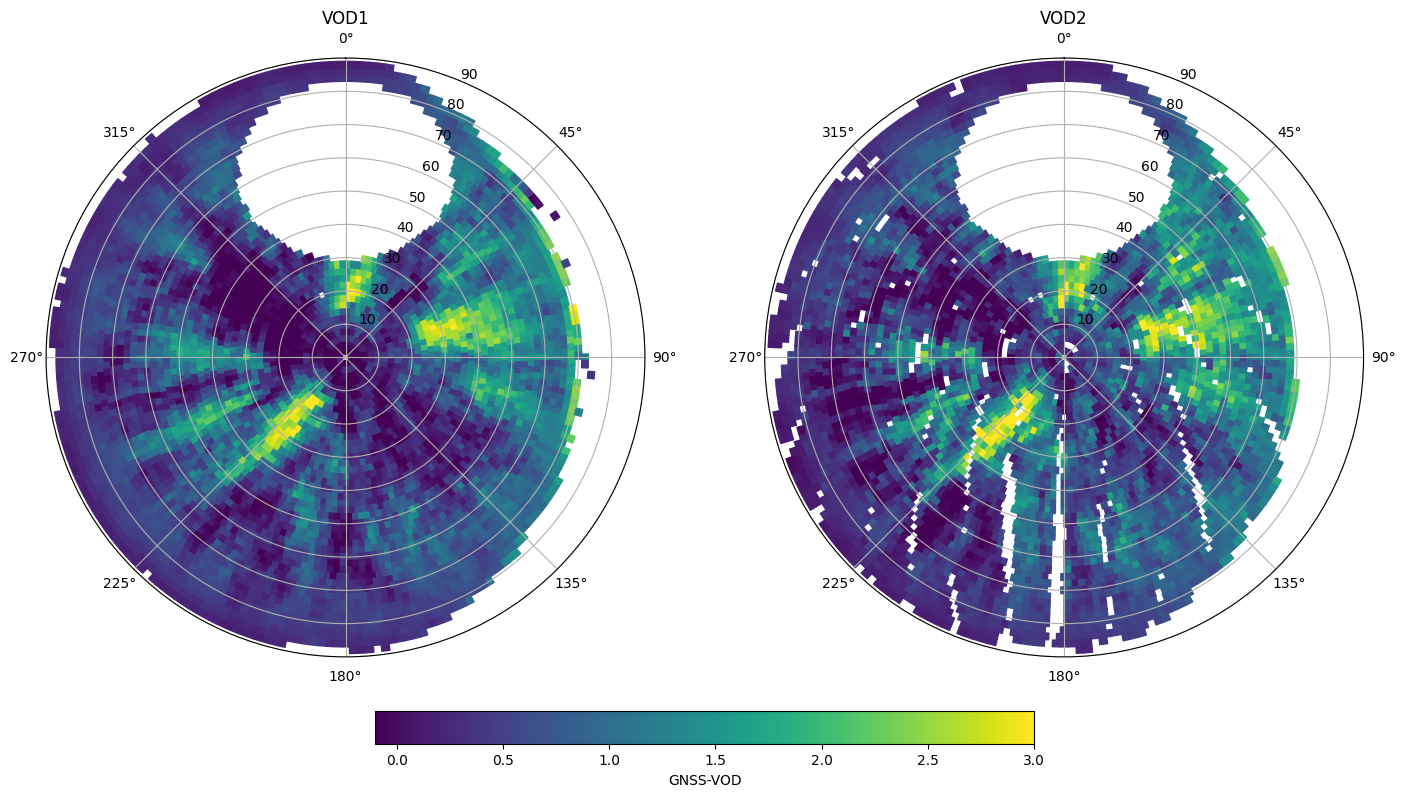

In [19]:
fig, ax = plt.subplots(1,2,figsize=(17,14),subplot_kw=dict(projection='polar'))

vod_names = ['VOD1','VOD2']
for i, iname in enumerate(vod_names):
    # associate the mean values to the patches, join inner will drop patches with no data, making plotting slightly faster
    # change the "vodavg_xx" section to match the vod_avg variable in your dataframe
    ipatches = pd.concat([patches,vod_avgMP[f"{iname}_mean"]],join='inner',axis=1)
    # plotting with colored patches
    pc = PatchCollection(ipatches.Patches,array=ipatches[f"{iname}_mean"],edgecolor='face', linewidth=1)
    pc.set_clim([-0.1,3])
    ax[i].add_collection(pc)
    ax[i].set_rlim([0,90])
    ax[i].set_theta_zero_location("N")
    ax[i].set_theta_direction(-1)
    ax[i].set_title(iname)

plt.colorbar(pc, ax=ax, location='bottom', shrink=.5, pad=0.05, label='GNSS-VOD')

To only plot the average VOD:

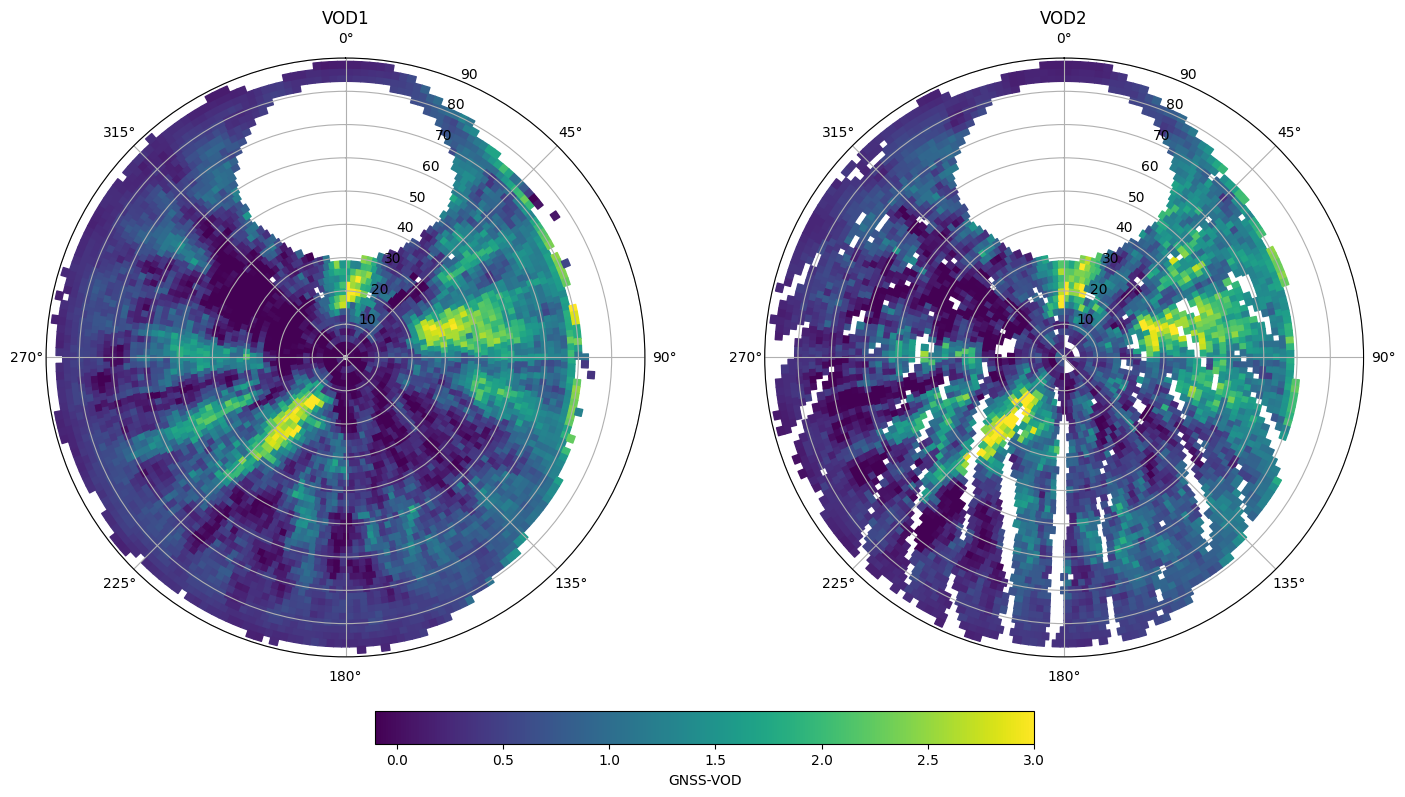

In [20]:
fig, ax = plt.subplots(1,2,figsize=(17,14),subplot_kw=dict(projection='polar'))

vod_names = ['VOD1','VOD2']
for i, iname in enumerate(vod_names):
    # associate the mean values to the patches, join inner will drop patches with no data, making plotting slightly faster
    # change the "vodavg_xx" section to match the vod_avg variable in your dataframe
    ivod_data = vod_avgMP[f"{iname}_mean"].where(vod_avgYP[f"{iname}_count"]>40)
    ipatches = pd.concat([patches,ivod_data],join='inner',axis=1)
    # plotting with colored patches
    pc = PatchCollection(ipatches.Patches,array=ipatches[f"{iname}_mean"],edgecolor='face', linewidth=1)
    pc.set_clim([-0.1,3])
    ax[i].add_collection(pc)
    ax[i].set_rlim([0,90])
    ax[i].set_theta_zero_location("N")
    ax[i].set_theta_direction(-1)
    ax[i].set_title(iname)

plt.colorbar(pc, ax=ax, location='bottom', shrink=.5, pad=0.05, label='GNSS-VOD')